### Imports & Setup

In [2]:
# === Standard Library ===
from pathlib import Path

# === Third-Party Libraries ===
# Data Handling
import pandas as pd
import numpy as np
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
from matplotlib.ticker import FuncFormatter
import shap
# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay

sns.set_theme()

# Function to save figure
def save_fig(fig, file_name):
    output_path = Path.cwd() / "figures" / file_name # Directory where plots will be saved
    fig.savefig(output_path, dpi=500, bbox_inches="tight")
    print(f"Saved to: {output_path}")


### Training RandomForest Model + SHAP Values

In [3]:
# Load cleaned data
file_path = Path.cwd().parent / "data" / "clean" / "final_quotes.csv"
df = pd.read_csv(file_path)

# Define features and target
X = df.drop(columns=["Premium (£)", "ln(Premium)"])  # drop original
y = df["ln(Premium)"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Training model
# Can use lower n_estimators to reduce computing time when replicating (random state is important for replicability)
model = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# SHAP values
explainer = shap.TreeExplainer(model, X_train)
shap_values = explainer(X_test)


100%|===================| 3539/3545 [06:02<00:00]        

### 1\). Distribution of Premiums (Raw & log-transformed)

Saved to: c:\Users\Andrew\Documents\code_projects\Assignments\Y2\Empirical_Project\notebooks_dev\figures\Fig1-premdist


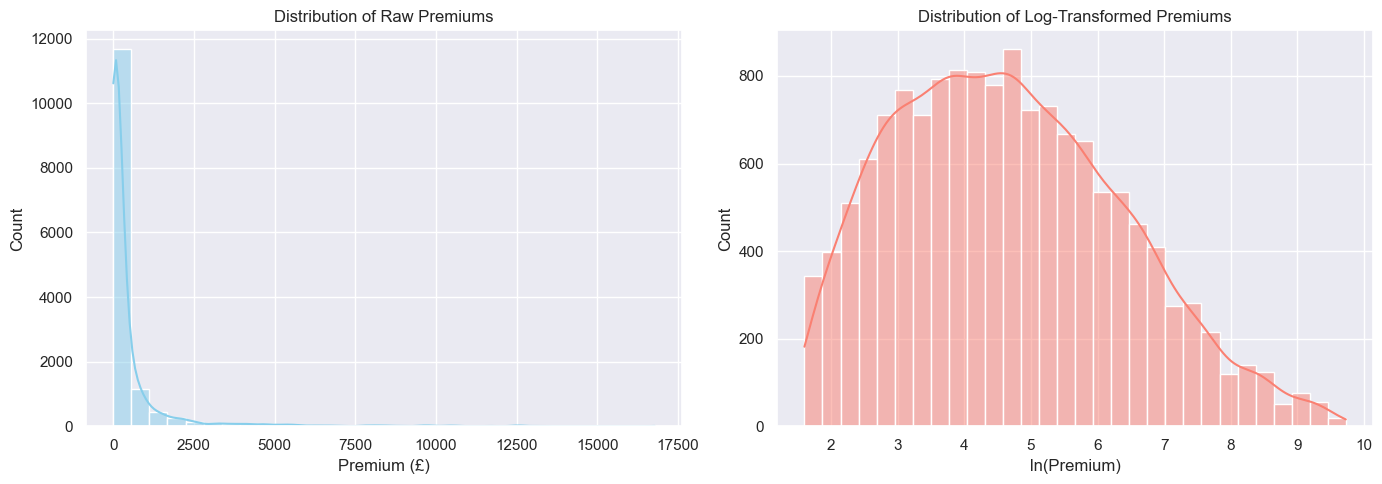

In [4]:
# --- Distribution of Premiums (Raw & Log) ---
# Displays side-by-side histograms of raw and log-transformed premiums.
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

# Plotting Raw premium distribution
sns.histplot(df["Premium (£)"], bins=30, kde=True, ax=axes[0], color="skyblue")
axes[0].set_title("Distribution of Raw Premiums")

# Plotting log-transformed premium
sns.histplot(df["ln(Premium)"], bins=30, kde=True, ax=axes[1], color="salmon")
axes[1].set_title("Distribution of Log-Transformed Premiums")

plt.tight_layout()
save_fig(plt, "Fig1-premdist") # Saving
plt.show()


### 2\). Correlation Matrix

Saved to: c:\Users\Andrew\Documents\code_projects\Assignments\Y2\Empirical_Project\notebooks_dev\figures\Fig2-corrhmap


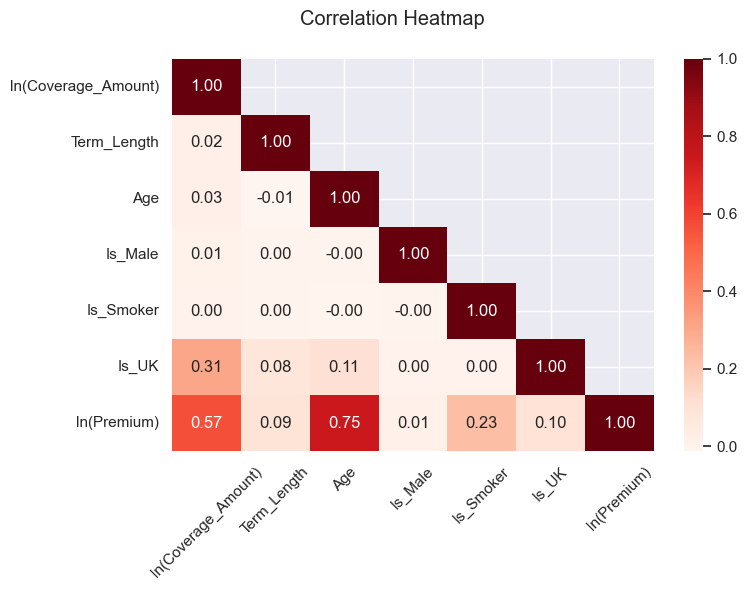

In [5]:
# --- Correlation Matrix ---
# Displays heatmap of correlations across all numeric features, except the raw premium.
plt.figure(figsize=(8, 6))

# Forming our correlation matrix 
corr = df.drop(columns="Premium (£)").corr()

# Getting the Upper Triangle of the co-relation matrix
mask = np.triu(corr)
# Including the main diagonal
np.fill_diagonal(mask, False)

# Plotting our heatmap
sns.heatmap(corr, annot=True, mask=mask, cmap="Reds", fmt=".2f")
plt.xticks(rotation=45)
plt.suptitle("Correlation Heatmap")

plt.tight_layout()
save_fig(plt, "Fig2-corrhmap") # Saving
plt.show()

### 3\). FacetGrid: Avg Premiums by Demographics

Saved to: c:\Users\Andrew\Documents\code_projects\Assignments\Y2\Empirical_Project\notebooks_dev\figures\Fig3-avgdem


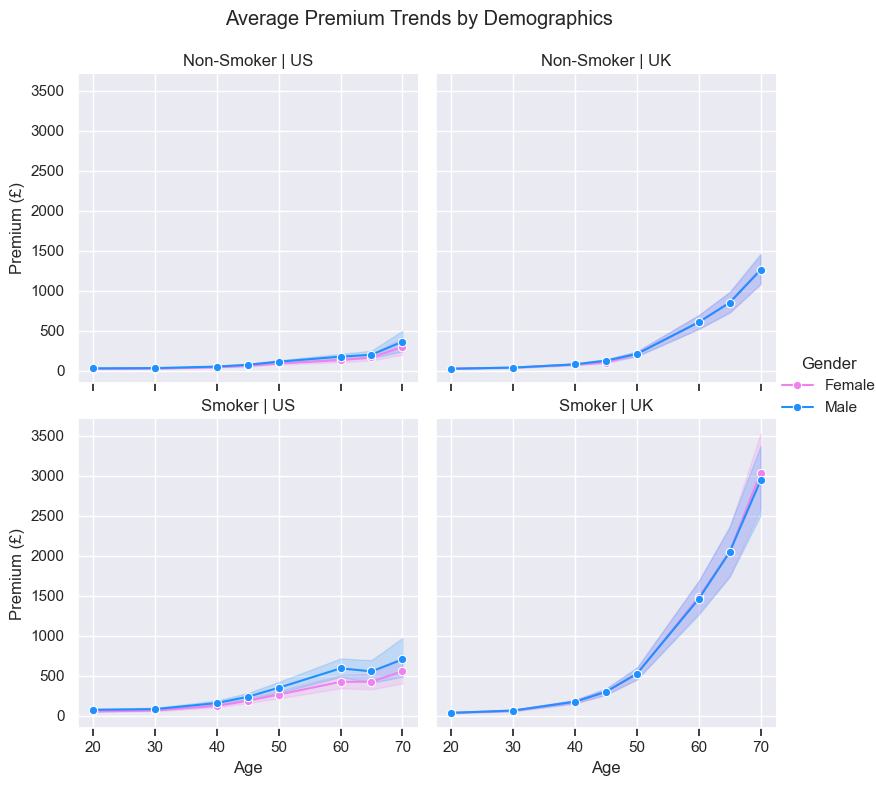

In [6]:
# --- Average Premium Trends by Demographics ---
# Visualises premium trends across Age, Gender, Smoking status, and UK residency using FacetGrid.

# === Setting up the FacetGrid: by UK residency (columns), Smoking status (rows), colored by gender ===
g = sns.FacetGrid(df, col="Is_UK", row="Is_Smoker", hue="Is_Male", height=4, palette={"dodgerblue", "violet"})

# Plotting lineplot of age vs. premium in each subplot
g.map_dataframe(sns.lineplot, x="Age", y="Premium (£)", marker="o")
plt.subplots_adjust(top=0.9) # Making space for suptitle
g.tick_params(bottom=True) # Adding tick marks
g.figure.suptitle("Average Premium Trends by Demographics")

# Adding our legend
g.add_legend(title="Gender")
for t, l in zip(g._legend.texts, ["Female", "Male"]):
    t.set_text(l)
g._legend.set_bbox_to_anchor((1.025, 0.5))  # Moving legend to remove overlap

# === Setting more descriptive titles for subplots manually ===
# Creating our dictionary, where (False, False) maps to "Non-Smoker | US" etc.,
titles = {(smoker, uk): f"{"Smoker" if smoker else "Non-Smoker"} | {"UK" if uk else "US"}" 
              for smoker in [False, True] for uk in [False, True]}

# Adding our titles
for (smoker_status, uk_status), ax in g.axes_dict.items():
    ax.set_title(titles[(smoker_status, uk_status)])
save_fig(plt, "Fig3-avgdem") # Saving
plt.show()

### 4\). Partial Dependence Plots (PDPs) for Age, Log Coveage, and Term Length

Saved to: c:\Users\Andrew\Documents\code_projects\Assignments\Y2\Empirical_Project\notebooks_dev\figures\Fig4-PDPs


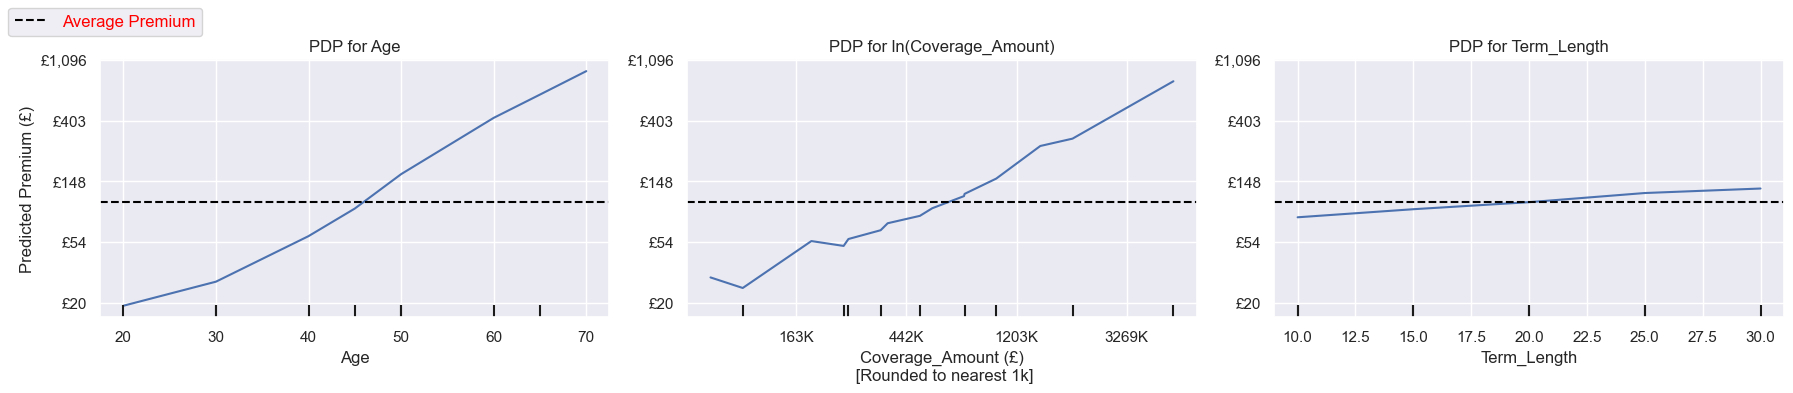

In [7]:
# -- PDPs for Age, ln(Coverage_Amount) and Term_Length ---
# Visualising the marginal effect of key features on the model's predicted log premium.

# Defining the features we want to explore in the PDPs
features_to_plot = ["Age", "ln(Coverage_Amount)", "Term_Length"]

# Creating subplots: one for each feature
fig, ax = plt.subplots(1, len(features_to_plot), figsize=(6 * len(features_to_plot), 4))

# Generating PDPs for the selected features using the trained model
disp = PartialDependenceDisplay.from_estimator(model, X, features_to_plot, ax=ax)

# Computing the global prediction average for reference line (from test set)
global_prediction = np.mean(model.predict(X_test))

# Formatting subplot titles and overlaying a horizontal line for the global average prediction
for axis, feature in zip(ax, features_to_plot):
    axis.set_title(f'PDP for {feature}')
    axis.axhline(global_prediction, color='black', linestyle='--', linewidth=1.5, label='Average Premium')
    
# Relabelling y-axis and x-axis to show raw premiums
for i, axis in enumerate(ax):
    axis.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"£{int(np.exp(y)):,}"))
    # Only for the ln(Coverage_Amount) plot
    if features_to_plot[i] == "ln(Coverage_Amount)":
        axis.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{round(np.exp(x) / 1e3) * 1e3 / 1e3:.0f}K"))
        axis.set_xlabel("Coverage_Amount (£)\n [Rounded to nearest 1k]")

# Labelling only the first y-axis to avoid clutter
for i, axis in enumerate(ax):
    if i != 0:
        axis.set_ylabel("")
    else:
        axis.set_ylabel("Predicted Premium (£)")

# Creating a single figure-level legend
legend_handle = mlines.Line2D([], [], color='black', linestyle='--', linewidth=1.5, label='Average Premium')
fig.legend(handles=[legend_handle], loc='upper left', ncol=1, fontsize="medium", labelcolor="red")

# Adjusting layout to make space for legend
plt.tight_layout(rect=[0, 0, 1, 0.95])
save_fig(plt, "Fig4-PDPs")
plt.show()


### 5\). Individual Conditional Expectation (ICE) plots by Group

Saved to: c:\Users\Andrew\Documents\code_projects\Assignments\Y2\Empirical_Project\notebooks_dev\figures\Fig5-ICEs


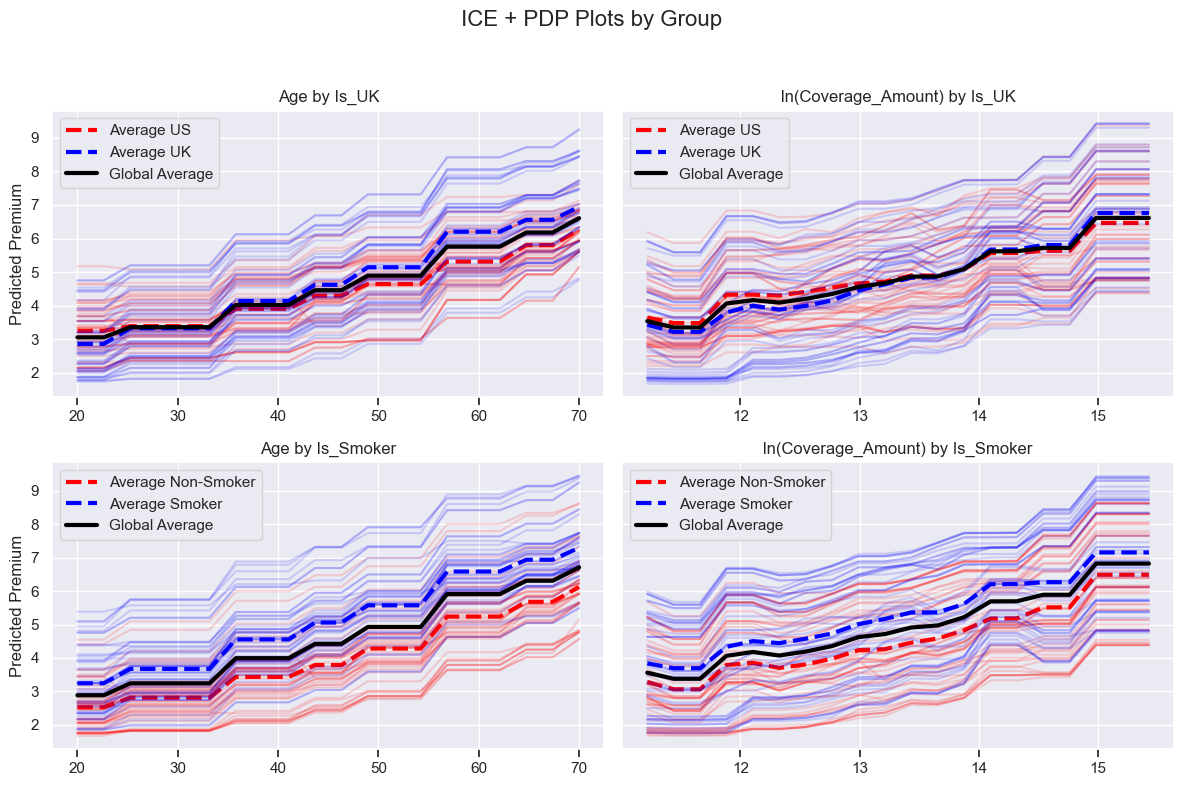

In [8]:
# --- ICE + PDP for Age & ln(Coverage_Amounts), by UK/US and Smoking Status
# Displaying marginal effects on both individuals and category averages (country and smoking status), to reveal further trends.

# === Configuration ===
features = ["Age", "ln(Coverage_Amount)"]   # Features to analyse (one per column in subplot)
group_vars = ["Is_UK", "Is_Smoker"]         # Categorical grouping vars (one per row)
grid_resolution = 20                        # Number of points to compute per feature
individuals_per_group = 50                  # Max individuals to sample per group for ICE
group_colors = {0: "red", 1: "blue"}        # Consistent coloring per binary group

# Custom labels for legend display
label_mappings = {
    "Is_UK": {0: "US", 1: "UK"},
    "Is_Smoker": {0: "Non-Smoker", 1: "Smoker"}
}

# Setting up subplots
fig, axes = plt.subplots(2, 2, figsize=(6 * 2, 4 * 2), sharey='row')
fig.suptitle("ICE + PDP Plots by Group", fontsize=16)


# === Iterating through each subplot, feature (cols) × group var (rows) ===
for i, feature in enumerate(features):
    for j, group_var in enumerate(group_vars):
        ax = axes[j, i] # Accessing current subplot axis
        feature_vals = np.linspace(X_test[feature].min(), X_test[feature].max(), grid_resolution) # Grid of values to plot
        
        all_ice_lines = [] # Tracking for global pDP overlay

        # Plotting separately for each group value (0 or 1)
        for group_val in sorted(X_test[group_var].unique()):
            # Convert 0/1 to readable label (e.g., "Smoker" vs "Non-Smoker")
            mapped_label = label_mappings.get(group_var, {}).get(group_val, f"{group_var} = {group_val}")
            label = f"{mapped_label}"
            color = group_colors.get(group_val, "gray")

            # Filter go group-specific samples, then randomly sample individuals
            group_df = X_test[X_test[group_var] == group_val].copy()
            sample_df = group_df.sample(min(individuals_per_group, len(group_df)), random_state=42)

            ice_lines = []
            # Generate ICE curves for sampled individuals
            for _, row in sample_df.iterrows():
                X_temp = pd.DataFrame([row] * grid_resolution)  # Duplicate row for manipulation
                X_temp[feature] = feature_vals                  # Vary the feature of interest
                preds = model.predict(X_temp)
                ice_lines.append(preds)
                all_ice_lines.append(preds)
                ax.plot(feature_vals, preds, alpha=0.15, color=color) # Plotting individual ICE lines

            # Add PDP (mean of ICE) per group
            mean_preds = np.mean(ice_lines, axis=0)
            ax.plot(feature_vals, mean_preds, label=f"Average {label}", linewidth=3, color=color, linestyle="--")

        # Adding global PDP overlay (if any lines exist)
        if all_ice_lines:
            global_pdp = np.mean(all_ice_lines, axis=0)
            ax.plot(feature_vals, global_pdp, label="Global Average", linewidth=3, color="black")
            

        # Label formatting
        ax.set_title(f"{feature} by {group_var}")
        ax.tick_params(bottom=True)
        ax.set_ylabel("Predicted Premium" if i == 0 else "")  # Y label on first col only
        ax.legend()
        
# Adjusting spacing to avoid overlap with suptitle
plt.tight_layout(rect=[0, 0, 1, 0.95])
save_fig(plt, "Fig5-ICEs")
plt.show()


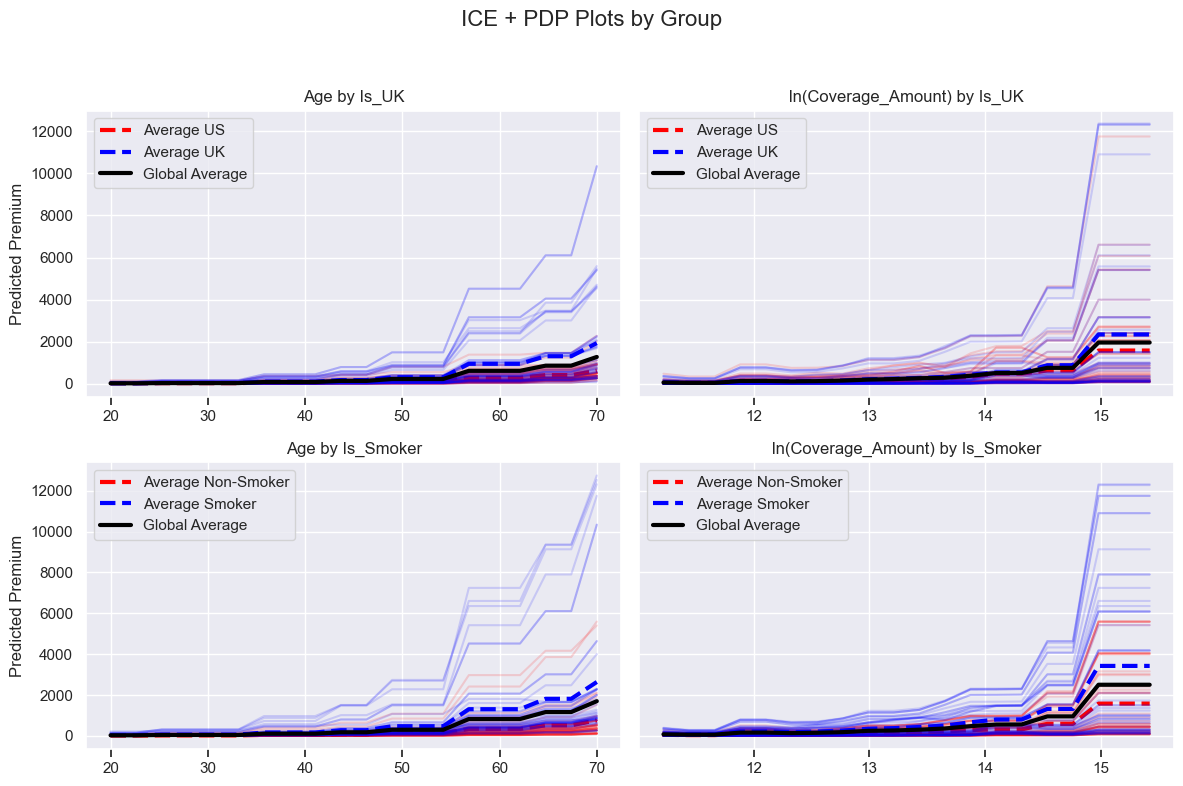

In [9]:
#TODO: change if include

# --- ICE + PDP for Age & ln(Coverage_Amounts), by UK/US and Smoking Status
# === Configuration ===
features = ["Age", "ln(Coverage_Amount)"]   # Features to analyse (one per column in subplot)
group_vars = ["Is_UK", "Is_Smoker"]         # Categorical grouping vars (one per row)
grid_resolution = 20                        # Number of points to compute per feature
individuals_per_group = 50                  # Max individuals to sample per group for ICE
group_colors = {0: "red", 1: "blue"}        # Consistent coloring per binary group

# Custom labels for legend display
label_mappings = {
    "Is_UK": {0: "US", 1: "UK"},
    "Is_Smoker": {0: "Non-Smoker", 1: "Smoker"}
}

# Setting up subplots
fig, axes = plt.subplots(2, 2, figsize=(6 * 2, 4 * 2), sharey='row')
fig.suptitle("ICE + PDP Plots by Group", fontsize=16)


# === Iterating through each subplot, feature (cols) × group var (rows) ===
for i, feature in enumerate(features):
    for j, group_var in enumerate(group_vars):
        ax = axes[j, i] # Accessing current subplot axis
        feature_vals = np.linspace(X_test[feature].min(), X_test[feature].max(), grid_resolution) # Grid of values to plot
        
        all_ice_lines = [] # Tracking for global pDP overlay

        # Plotting separately for each group value (0 or 1)
        for group_val in sorted(X_test[group_var].unique()):
            # Convert 0/1 to readable label (e.g., "Smoker" vs "Non-Smoker")
            mapped_label = label_mappings.get(group_var, {}).get(group_val, f"{group_var} = {group_val}")
            label = f"{mapped_label}"
            color = group_colors.get(group_val, "gray")

            # Filter go group-specific samples, then randomly sample individuals
            group_df = X_test[X_test[group_var] == group_val].copy()
            sample_df = group_df.sample(min(individuals_per_group, len(group_df)), random_state=42)

            ice_lines = []
            # Generate ICE curves for sampled individuals
            for _, row in sample_df.iterrows():
                X_temp = pd.DataFrame([row] * grid_resolution)  # Duplicate row for manipulation
                X_temp[feature] = feature_vals                  # Vary the feature of interest
                preds = np.exp(model.predict(X_temp))           # Predict and revert log-transform
                ice_lines.append(preds)
                all_ice_lines.append(preds)
                ax.plot(feature_vals, preds, alpha=0.15, color=color) # Plotting individual ICE lines

            # Add PDP (mean of ICE) per group
            mean_preds = np.mean(ice_lines, axis=0)
            ax.plot(feature_vals, mean_preds, label=f"Average {label}", linewidth=3, color=color, linestyle="--")

        # Adding global PDP overlay (if any lines exist)
        if all_ice_lines:
            global_pdp = np.mean(all_ice_lines, axis=0)
            ax.plot(feature_vals, global_pdp, label="Global Average", linewidth=3, color="black")

        # Label formatting
        ax.set_title(f"{feature} by {group_var}")
        ax.tick_params(bottom=True)
        ax.set_ylabel("Predicted Premium" if i == 0 else "")  # Y label on first col only
        ax.legend()
        
# Adjusting spacing to avoid overlap with suptitle
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



### 6\). SHAP Feature Importance Bar Plot

Saved to: c:\Users\Andrew\Documents\code_projects\Assignments\Y2\Empirical_Project\notebooks_dev\figures\Fig6-SHAPimp


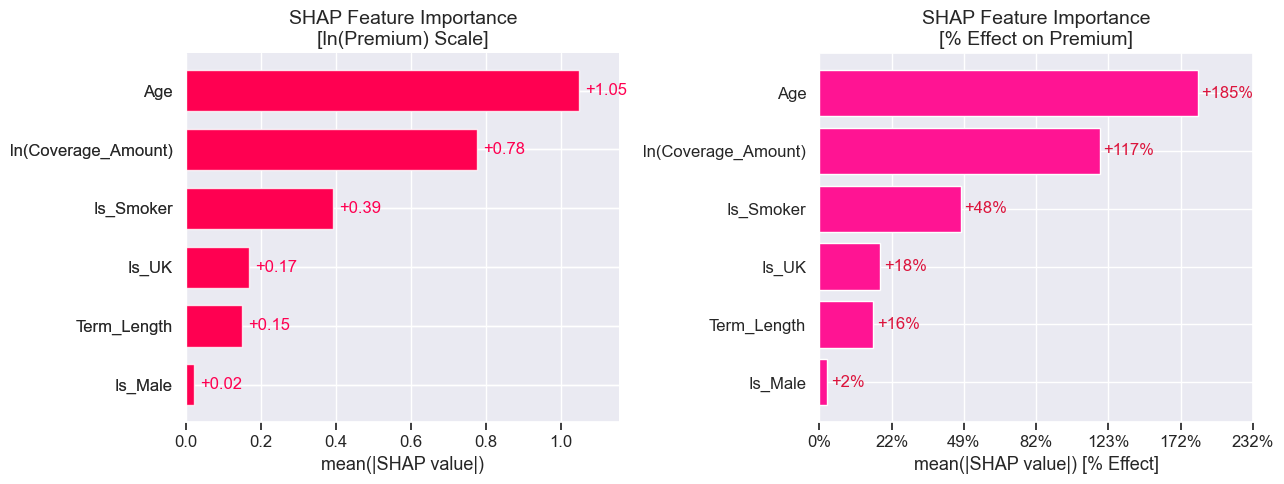

In [10]:
# --- SHAP Feature Importance Bar Plot ---
# Uses mean(|SHAP|) values (obtained from RandomForests) to assess global feature importance.

# Creating our subplots
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# === Left: Native SHAP Bar Plot on ln(Premium) Scale ===
shap.plots.bar(shap_values, show=False, ax=axes[0])
axes[0].set_title("SHAP Feature Importance\n[ln(Premium) Scale]", fontsize=14)
axes[0].set_xlabel("mean(|SHAP value|)", fontsize=13)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

# === Right: Custom Horizontal Bar plot in % Space ===
# Creating custom bar plot since shap.plots.bar does not support converiting to % change
shap_vals = np.abs(shap_values.values).mean(0) # mean(|SHAP|) across all samples (across axis 0)
features = np.array(shap_values.feature_names) # Feature names array

# Sorting features by importance (ascending order will be converted to descending by barh)
idx = np.argsort(shap_vals)
shap_vals, feats = shap_vals[idx], features[idx]

# Converting SHAP values from log-scale to % impact on premium
pct_effects = (np.exp(shap_vals) - 1) * 100

# Custom bar plot with % effect annotations
axes[1].barh(feats, shap_vals, color="deeppink")

# Converting to custom x-axis tick labels showing % effect
xtick_vals = axes[1].get_xticks()
xtick_pct_labels = [(np.exp(x) - 1) * 100 for x in xtick_vals]
axes[1].set_xticks(xtick_vals) # To avoid UserWarning
axes[1].set_xticklabels([f"{pct:.0f}%" for pct in xtick_pct_labels])

# Annotate each bar with the exact % increase
for i, val in enumerate(shap_vals):
    pct = (np.exp(val) - 1) * 100
    axes[1].text(val + 0.01, i, f"+{pct:.0f}%", va="center", color="crimson")

# Axis styling for consistence and clarity
axes[1].set_title("SHAP Feature Importance\n[% Effect on Premium]", fontsize=14)
axes[1].set_xlabel("mean(|SHAP value|) [% Effect]", fontsize=13)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='x', bottom=True)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)

plt.tight_layout()
save_fig(plt, "Fig6-SHAPimp") # Saving
plt.show()

### 7\). SHAP Beeswarm Plot

Saved to: c:\Users\Andrew\Documents\code_projects\Assignments\Y2\Empirical_Project\notebooks_dev\figures\Fig7-SHAPbee


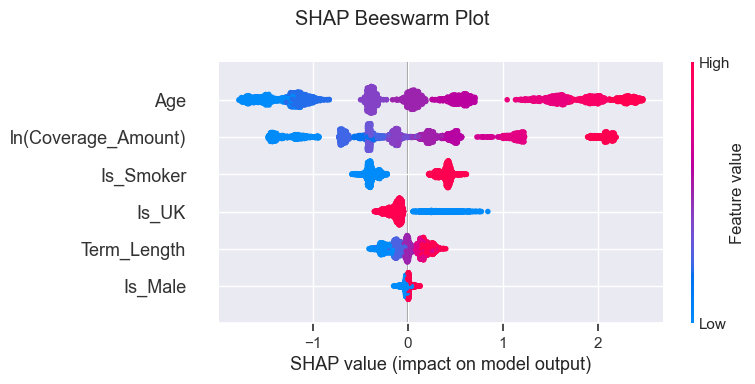

In [11]:
# --- SHAP Beeswarm Plot ---
# Used to assess how feature value dictates direction of effect (in this particular analysis)
plt.figure(figsize=(10, 6))
shap.plots.beeswarm(shap_values, show=False)
plt.suptitle("SHAP Beeswarm Plot")
plt.tight_layout()
save_fig(plt, "Fig7-SHAPbee") # Saving
plt.show()


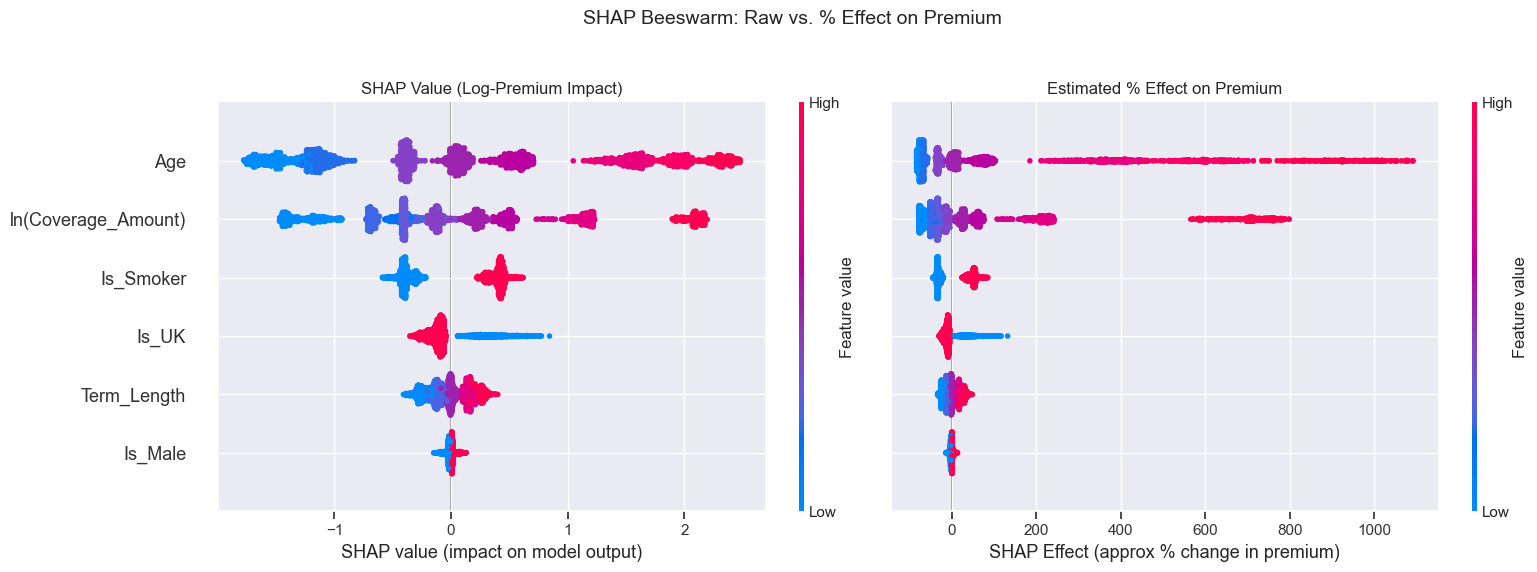

In [12]:
#TODO: IF INCLUDING MODIFY THIS

import matplotlib.pyplot as plt
import shap
import numpy as np

# Copy the shap values
shap_percent = shap_values.values.copy()
shap_percent = (np.exp(shap_percent) - 1) * 100  # Convert to % effect

# --- Plotting side-by-side ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# --- Left: Original SHAP (log-scale) ---
shap.plots.beeswarm(shap_values, show=False, ax=axes[0], plot_size=None)
axes[0].set_title("SHAP Value (Log-Premium Impact)")

# --- Right: Converted % effect ---
# Construct a new SHAP values object with same metadata
shap_percent_obj = shap.Explanation(
    values=shap_percent,
    base_values=shap_values.base_values,
    data=shap_values.data,
    feature_names=shap_values.feature_names
)
shap.plots.beeswarm(shap_percent_obj, show=False, ax=axes[1], plot_size=None)
axes[1].set_title("Estimated % Effect on Premium")
axes[1].set_xlabel("SHAP Effect (approx % change in premium)")

plt.suptitle("SHAP Beeswarm: Raw vs. % Effect on Premium", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 8\). Waterfall Plots

Saved to: c:\Users\Andrew\Documents\code_projects\Assignments\Y2\Empirical_Project\notebooks_dev\figures\Fig8-SHAPwater


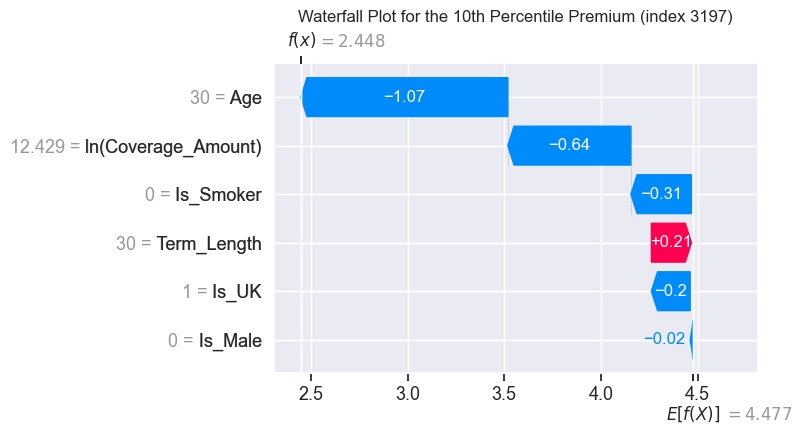

Saved to: c:\Users\Andrew\Documents\code_projects\Assignments\Y2\Empirical_Project\notebooks_dev\figures\Fig9-SHAPwater


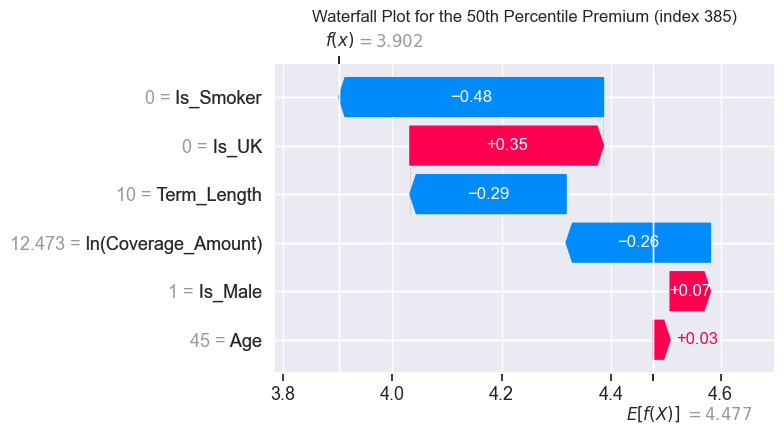

Saved to: c:\Users\Andrew\Documents\code_projects\Assignments\Y2\Empirical_Project\notebooks_dev\figures\Fig10-SHAPwater


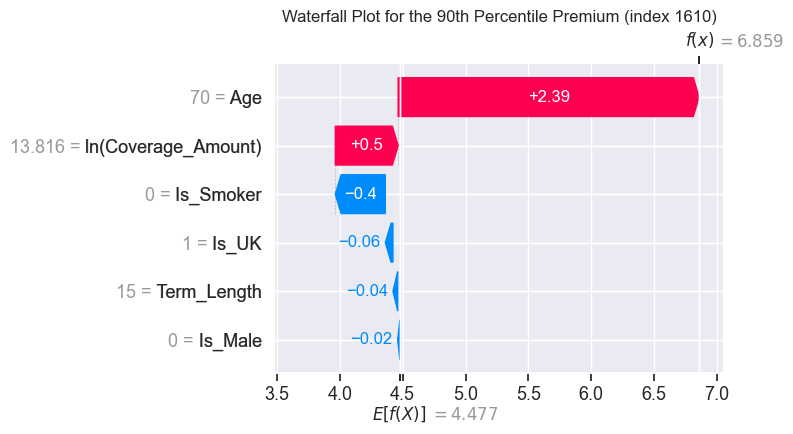

In [13]:
# --- 
percentiles = [10, 50, 90] # Percentiles for which to generate plots
# Calculating percentiles for the target variable (ln(premium) or predictions)
ln_premium_percentiles = np.percentile(y_test, percentiles)

for i, (p, ln_premium), in enumerate(zip(percentiles, ln_premium_percentiles)):
    # Getting index of closest value in y_test to the percentile
    idx = np.argmin(np.abs(y_test - ln_premium))  
    shap.plots.waterfall(shap_values[idx], show=False)  # Plotting SHAP values for this sample
    plt.title(f"Waterfall Plot for the {p}th Percentile Premium (index {idx})")
    plt.tight_layout()
    save_fig(plt, f"Fig{8+i}-SHAPwater") # Saving iteratively
    plt.show()